In [1]:
import pandas as pd

In [2]:
import requests
from requests.exceptions import HTTPError, Timeout
import time
import re

class SPARQLResponse():
    def __init__(self, data) -> None:
        self.data = data
        if isinstance(data, dict):
            if "results" in data and "bindings" in data["results"]:
                self.bindings = data['results']['bindings']
                self.success = True
        else:
            self.bindings = False
            self.success = False

def is_query_empty(query :str) -> bool:
    query = query.strip()
    return query is None or query == "" or len(query) == 0

# Modified from the original file to suit this notebook, but has the same functionality
def send_query_to_api(query, timeout_limit=60, num_try=3):
    response = None
    while num_try > 0 and response == None and not is_query_empty(query):
        try:
            sparql_response = execute_sparql(query, timeout=timeout_limit)
            response = sparql_response.bindings if sparql_response.success else sparql_response.data
                
        except HTTPError as inst:
            if inst.response.status_code == 429:
                retry_after = int(inst.response.headers['retry-after'])
                time.sleep(retry_after + 1)
                num_try -= 1
            else:
                response = "exception: " + str(inst) + "\n" + inst.response.text
        except Timeout:
            response = "timeout"
        except Exception as inst:
            response = "exception: " + str(inst)
    return response if response != None else "exception: too many retry-after"

def execute_sparql(query: str, timeout: int = None):
    url = 'https://query.wikidata.org/bigdata/namespace/wdq/sparql'
    response = requests.get(url, params={'query': query, 'format': 'json'}, headers={'User-agent': 'WikidataLLM bot v0'}, timeout=timeout)
    response.raise_for_status()
    
    try:
        data = SPARQLResponse(response.json())
    except requests.exceptions.JSONDecodeError:
        data = SPARQLResponse(response.text)
    
    return data

def classify_400_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_undefined_prefix = re.compile(r"undefined prefix")
    pattern_parse = re.compile(r"ast.ParseException")
    pattern_limit = re.compile(r"limit|LIMIT")
    pattern_lexical = re.compile(r"Lexical error")
    pattern_non_agg_var_in_sel = re.compile(r"Non-aggregate variable in select expression")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_undefined_prefix.search(last_error):
        errors.append("undefined prefix")
    if pattern_parse.search(last_error):
        if pattern_limit.search(last_error):
            errors.append("parse exception due to limit")
        else:
            errors.append("parse exception")
    if pattern_lexical.search(last_error):
        errors.append("lexical error")
    if pattern_non_agg_var_in_sel.search(last_error):
        errors.append("non-aggregate variable in select expression")
        
    return errors

def send_and_classify_400_errors(query: str):
    response = send_query_to_api(query)
    if isinstance(response, list):
        return ['false negative']
    else:
        stack = response.split("\n", maxsplit=1)[1]
        return classify_400_errors(stack)

def classify_500_errors(stack_trace: str):
    pattern = re.compile(r"Caused by: .+")
    pattern_stackoverflow = re.compile(r"StackOverflowError")
    pattern_geo_input_no_resolve_point = re.compile(r"Input could not be resolved as point")
    pattern_estimated_time_too_long = re.compile(r"The estimated execution time")
    
    reduced_stack = pattern.findall(stack_trace)
    last_error = reduced_stack[len(reduced_stack)-1]
    
    errors = []
    if pattern_stackoverflow.search(last_error):
        errors.append("stack overflow")
    if pattern_geo_input_no_resolve_point.search(last_error):
        errors.append("GeoSpatialSearchException: input could not be resolved as point")
    if pattern_estimated_time_too_long.search(last_error):
        errors.append("estimated time to execute too long")
        
    return errors

def send_and_classify_500_errors(query: str):
    response = send_query_to_api(query)
    if isinstance(response, list):
        return ['false negative']
    else:
        stack = response.split("\n", maxsplit=1)[1]        
        return classify_500_errors(stack)
    

In [3]:
df = pd.read_parquet("../datasets/queries_with_execution_and_limits_new.parquet.gzip", engine="fastparquet")
df = df[['query', 'execution', 'executed_query']]

In [4]:
df_timeout = df.loc[df['execution'] == 'timeout']
df_fail = df.loc[df['execution'].str.startswith('exception')]
df_empty = df.loc[df['execution'].isnull()]
df_successful = df.drop(df_timeout.index).drop(df_fail.index).drop(df_empty.index)

In [5]:
df_fail

,query,execution,executed_query
index,,,
24,SELECT ?iso ?countryLabel (SUM(?stars) as ?sta...,exception: 500 Server Error: Internal Server E...,SELECT ?iso ?countryLabel (SUM(?stars) as ?sta...
86,SELECT DISTINCT ?person ?personLabel ?personDe...,exception: 400 Client Error: Bad Request for u...,SELECT DISTINCT ?person ?personLabel ?personDe...
341,SELECT ?personLabel ?work ?workLabel ?pubyear ...,exception: 400 Client Error: Bad Request for u...,SELECT ?personLabel ?work ?workLabel ?pubyear ...
413,SELECT ?manufacturer ?manufacturerLabel (SUM(?...,exception: 500 Server Error: Internal Server E...,SELECT ?manufacturer ?manufacturerLabel (SUM(?...
418,"SELECT ?item ?itemLabel\n{\n?item wdt:P2093 ""B...",exception: 400 Client Error: Bad Request for u...,"SELECT ?item ?itemLabel\n{\n?item wdt:P2093 ""B..."
...,...,...,...
2652,SELECT ?item ?articlename ?itemLabel ?itemDesc...,exception: 400 Client Error: Bad Request for u...,SELECT ?item ?articlename ?itemLabel ?itemDesc...
2656,SELECT ?count ?topic ?taxonname\nWITH {\nSELEC...,exception: 400 Client Error: Bad Request for u...,SELECT ?count ?topic ?taxonname\nWITH {\nSELEC...
2760,SELECT DISTINCT ?author ?geo\nWITH {\nSELECT D...,exception: 400 Client Error: Bad Request for u...,SELECT DISTINCT ?author ?geo\nWITH {\nSELECT D...


In [6]:
print(f"Number of timed out requests: {len(df_timeout)}")
print(f"Number of failed requests: {len(df_fail)}")
print(f"Number of empty responses: {len(df_empty)}")
print(f"Number of successful responses: {len(df_successful)}")

Number of timed out requests: 222
Number of failed requests: 151
Number of empty responses: 0
Number of successful responses: 2472


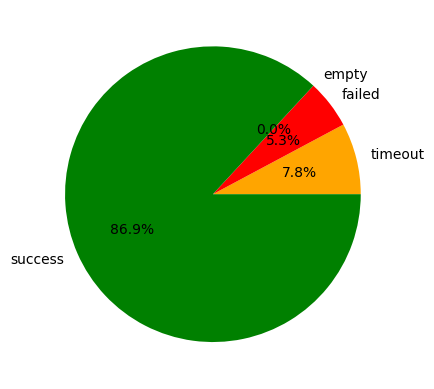

In [7]:
import matplotlib.pyplot as plt


labels = ["timeout", "failed", "empty", "success"]
sizes = [len(df_timeout), len(df_fail), len(df_empty), len(df_successful)]

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=["orange", "red", "grey", "green"])

In [8]:
import re

comp = re.compile(r"exception: ([0-9]+)")

def find_error_type(x: pd.Series):
    m = comp.search(x['execution'][:20])
    
    if m != None:
        return m.group(1)
    
    return None

df_fail['error_type'] = df_fail.apply(lambda x: find_error_type(x), axis=1)

distinct_errors = df_fail.error_type.unique()

print(f"There is {len(distinct_errors)} types of errors: {', '.join(map(lambda x: str(x), distinct_errors))}")
for err in distinct_errors:
    if err == None:
        print(f"Number of {str(err)}: {len(df_fail.loc[df_fail['error_type'].isnull()])}")
    else:
        print(f"Number of {str(err)}: {len(df_fail.loc[df_fail['error_type'] == err])}")

print()

for err in distinct_errors:
    if err == None:
        print(f"Example of {str(err)}: {df_fail.loc[df_fail['error_type'].isnull()].iloc[0]['execution']}")
    else:
        print(f"Example of {str(err)}: {df_fail.loc[df_fail['error_type'] == err].iloc[0]['execution']}")

There is 2 types of errors: 500, 400
Number of 500: 40
Number of 400: 111

Example of 500: exception: 500 Server Error: Internal Server Error for url: https://query.wikidata.org/bigdata/namespace/wdq/sparql?query=SELECT+%3Fiso+%3FcountryLabel+%28SUM%28%3Fstars%29+as+%3Fstars%29+%3Ffertility+WHERE+%7B%0A%7BSELECT+DISTINCT+%3Fcountry+%3Fiso+WHERE+%7B%0AVALUES+%3Fcountrytypes+%7Bwd%3AQ6256+wd%3AQ3624078%7D+%23+country+and+sovereign+state%0A%3Fcountry+wdt%3AP31+%3Fcountrytypes+%3B+wdt%3AP298+%3Fiso%0AMINUS+%7B%3Fcountry+wdt%3AP576+%5B%5D%7D+%23+Not+dissolved%0A%7D+%7D%0A%3Fcountry+wdt%3AP163+%3Fflag.%0AOPTIONAL%7B%0A%3Fflag+p%3AP180+%5Bps%3AP180+%3Ffeature+%3B+pq%3AP1114+%3Fstars%5D+.+%23+quantity+of+feature%0A%3Ffeature+wdt%3AP279%3F+wd%3AQ836708+%23+type+of+star+polygon%0A%7D%0AOPTIONAL+%7B+%3Fcountry+wdt%3AP4841+%3Ffertility+%7D%0ASERVICE+wikibase%3Alabel+%7B+bd%3AserviceParam+wikibase%3Alanguage+%22%5BAUTO_LANGUAGE%5D%2Cen%22.+%7D%0A%7D+GROUP+BY+%3Fiso+%3FcountryLabel+%3Ffertility%0AOR

C:\Users\Alexis Strappazzon\AppData\Local\Temp\ipykernel_23292\1239083386.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fail['error_type'] = df_fail.apply(lambda x: find_error_type(x), axis=1)


## Finding more about the reasons of the errors

We are sending once more a request, the same that has been sended. And then, using regular expressions we try to classify the error.

error_type
400    111
500     40
Name: count, dtype: int64


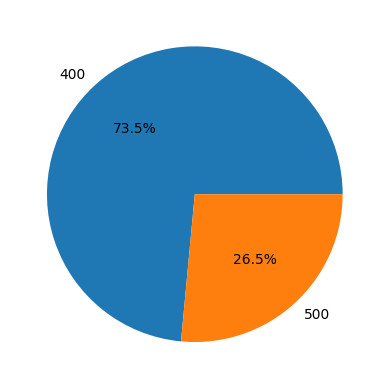

In [9]:
import matplotlib.pyplot as plt

value_counts = df_fail['error_type'].value_counts()
print(value_counts)

labels = list(df_fail['error_type'].value_counts().index)
sizes = list(value_counts)

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

In [11]:
df_error400 = df_fail.loc[df_fail['error_type'] == '400'].copy()
df_error400['error_classified'] = df_error400.apply(lambda x: send_and_classify_400_errors(x['executed_query']), axis=1)

### 400 Client Error

When investigation errors from the "400 Client Error" family we find out 5 reasons (ordered by frequency):
1. The query uses a prefix that is unknown to wikidata.
2. Lexical errors due to unescaped character.
3. Parse exception, the query is not well formated. A manual review, reveals that some of the requests have still fragment from the web crawling or were not fully captured.
4. Parse exception due to the LIMIT clause that were artificially added to restrict answer length. The base query might be formatted in a way that works, but when adding the LIMIT clause it broke down. However, it can be formated (moving some curly braces) to work again.
5. Non-aggregate variable in select expression.

It is hard to see how to correct these queries automatically, however reasons 1, 2, 4 and 5 could be manually modified. The problem with 3 is that for some queries, we just don't have the ending of it.

#### A closing brackets that works without the LIMIT clause but not with (query index 441)

The closing bracket of the (unexplicit) WHERE is just before the VALUES clause. Which does not allows to add a LIMIT clause. Just moving this brackets to the end of VALUES doesn't only keep the same results but allows for the use of LIMIT.

Problem: I cannot think of a trivial solution to this problem.

Under the **not working** query.
```sparql
SELECT ?item ?itemLabel WHERE {
  ?item wdt:P108 ?employer.
  FILTER(NOT EXISTS {
    ?item ?wdt _:b7.
    ?wdt (^wikibase:directClaim/wdt:P31/(wdt:P279*)) wd:Q18614948.
  })
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
values (?employer) {(wd:Q1138080)}
LIMIT 10
```

Under the **working** query.
```sparql
SELECT ?item ?itemLabel WHERE {
  ?item wdt:P108 ?employer.
  FILTER(NOT EXISTS {
    ?item ?wdt _:b2.
    ?wdt (^wikibase:directClaim/wdt:P31/(wdt:P279*)) wd:Q18614948.
  })
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
  VALUES ?employer {
    wd:Q1138080
  }
}
LIMIT 10
```

As stated before, it is just a question of curly braces for some queries.

error_classified
[undefined prefix]                               47
[lexical error]                                  36
[parse exception]                                16
[parse exception due to limit]                   11
[non-aggregate variable in select expression]     1
Name: count, dtype: int64


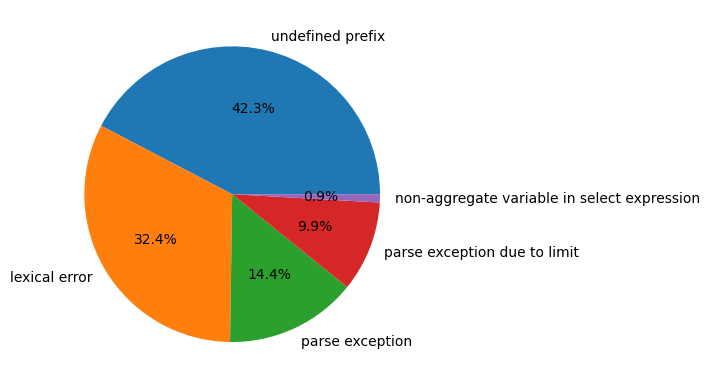

In [12]:
import matplotlib.pyplot as plt

value_counts = df_error400.error_classified.value_counts()
print(value_counts)

labels = list(map(lambda x: ", ".join(x), list(df_error400.error_classified.value_counts().index)))
sizes = list(value_counts)

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')

In [13]:
df_error500 = df_fail.loc[df_fail['error_type'] == '500'].copy()
df_error500['error_classified'] = df_error500.apply(lambda x: send_and_classify_500_errors(x['executed_query']), axis=1)

### 500 Server Error

Looking closer at queries that produces a "500 Server Issue" status, we can distinguish 3 categories. Rather surprising, some queries that were not working, were in fact working when analyzed further. However, looking at the numbers, we can see that the vast majority of 500 errors are due to Stack Overflow issue. Then to GeoSpatialSearch that couldn't resolve inputs as geographical point. And finally, one query was estimated to take too long to execute and was cutted short before execution.

It is unclear how we can "save" those queries. Except for the GeoSpatialSearchException, for other queries it might be possible to modify them in a way to use less recursion or data. Like 400 errors family, they most likely need a manual editing as an automatic one is not trivial.

error_classified
[stack overflow]                                                     34
[GeoSpatialSearchException: input could not be resolved as point]     3
[false negative]                                                      2
[estimated time to execute too long]                                  1
Name: count, dtype: int64


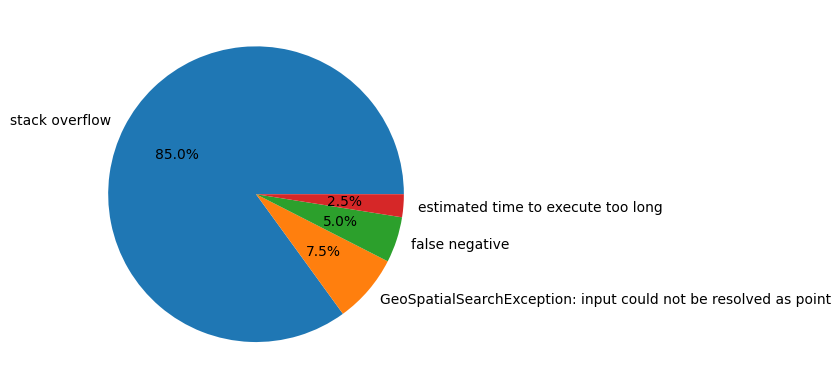

In [14]:
import matplotlib.pyplot as plt

value_counts = df_error500.error_classified.value_counts()
print(value_counts)

labels = list(map(lambda x: ", ".join(x), list(df_error500.error_classified.value_counts().index)))
sizes = list(value_counts)

fig, ax = plt.subplots()
ax = ax.pie(sizes, labels=labels, autopct='%1.1f%%')